In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.metrics import (precision_score, recall_score, 
                             confusion_matrix, accuracy_score,
                             roc_curve, auc)
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from keras.models import Sequential
from keras.layers import Dense

In [39]:
ROOT_PATH = Path().resolve().parent
dataset_path = ROOT_PATH / "data/airlines_delay.csv"

In [40]:
dataset = pd.read_csv(dataset_path, sep=",")
dataset.head()

,Flight,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class
0,2313.0,1296.0,141.0,DL,ATL,HOU,1,0
1,6948.0,360.0,146.0,OO,COS,ORD,4,0
2,1247.0,1170.0,143.0,B6,BOS,CLT,3,0
3,31.0,1410.0,344.0,US,OGG,PHX,6,0
4,563.0,692.0,98.0,FL,BMI,ATL,4,0


In [41]:
dataset.dtypes

Flight         float64
Time           float64
Length         float64
Airline         object
AirportFrom     object
AirportTo       object
DayOfWeek        int64
Class            int64
dtype: object

In [42]:
dataset.describe()

,Flight,Time,Length,DayOfWeek,Class
count,539382.000000,539382.000000,539382.000000,539382.000000,539382.000000
mean,2427.927988,802.728161,132.202104,3.929666,0.445443
std,2067.431700,278.045546,70.117045,1.914666,0.497015
min,1.000000,10.000000,0.000000,1.000000,0.000000
25%,712.000000,565.000000,81.000000,2.000000,0.000000
50%,1809.000000,795.000000,115.000000,4.000000,0.000000
75%,3745.000000,1035.000000,162.000000,5.000000,1.000000
max,7814.000000,1439.000000,655.000000,7.000000,1.000000


In [43]:
print("Amount of Airlines:", len(dataset["Airline"].unique()))
print("Amount of AirportFrom:", len(dataset["AirportFrom"].unique()))
print("Amount of AirportTo:", len(dataset["AirportTo"].unique()))

Amount of Airlines: 18
Amount of AirportFrom: 293
Amount of AirportTo: 293


Too much Airlines and Places to make it binary as dummy.\
In this case I'll only make them become 'Factors'

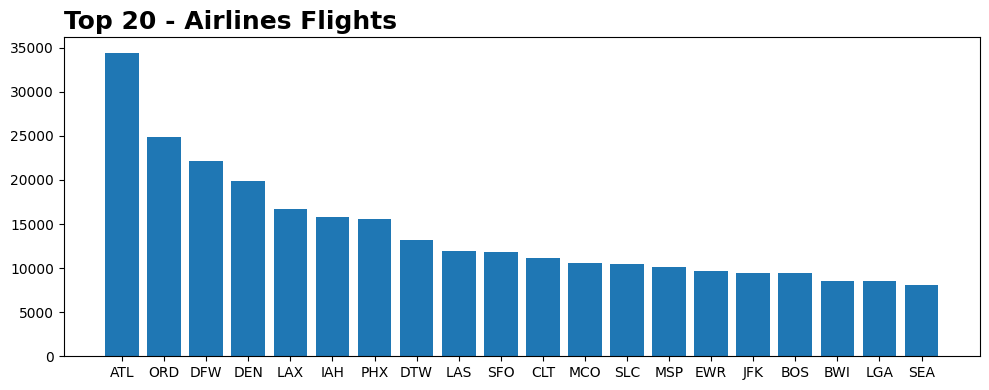

In [44]:
mostFlownAirlines = dataset.groupby(["AirportFrom"])["Airline"].count().sort_values(ascending=False)[:20]

plt.figure(figsize=(10, 4))
plt.bar(x=mostFlownAirlines.index, height=mostFlownAirlines.values)
plt.title(
    "Top 20 - Airlines Flights", 
    loc="left", 
    fontweight="bold", 
    fontsize=18
    )
plt.tight_layout()
plt.show()

#### Days with the major amount of Flights

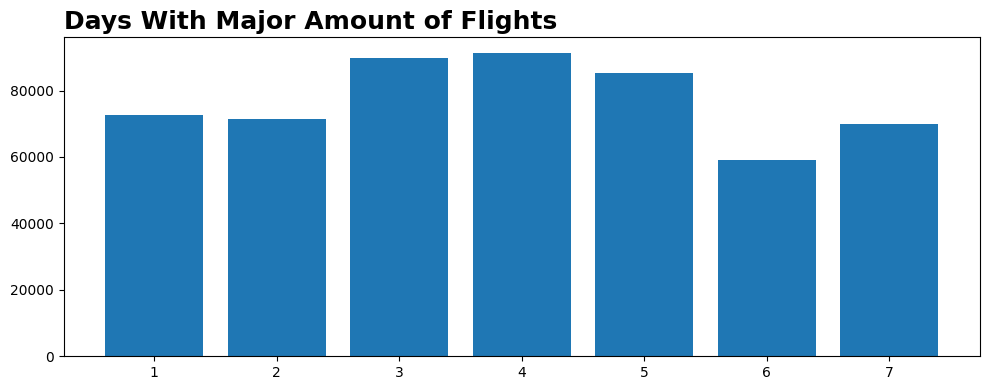

In [45]:
mostFlownDays = dataset.groupby(["DayOfWeek"])["DayOfWeek"].count().sort_values(ascending=False)

plt.figure(figsize=(10, 4))
plt.bar(x=mostFlownDays.index, height=mostFlownDays.values)
plt.title(
    "Days With Major Amount of Flights", 
    loc="left", 
    fontweight="bold", 
    fontsize=18
    )
plt.tight_layout()
plt.show()

Wednesday has more flights compared to the other days

#### Airline Flights Per Day

In [46]:
mostFlownDaysPerAirline = [
    (
    airline, 
    dataset[dataset["Airline"]==airline].groupby(
        ["DayOfWeek"]
        )["DayOfWeek"].count()
        ) for airline in dataset["Airline"].unique()
        ]

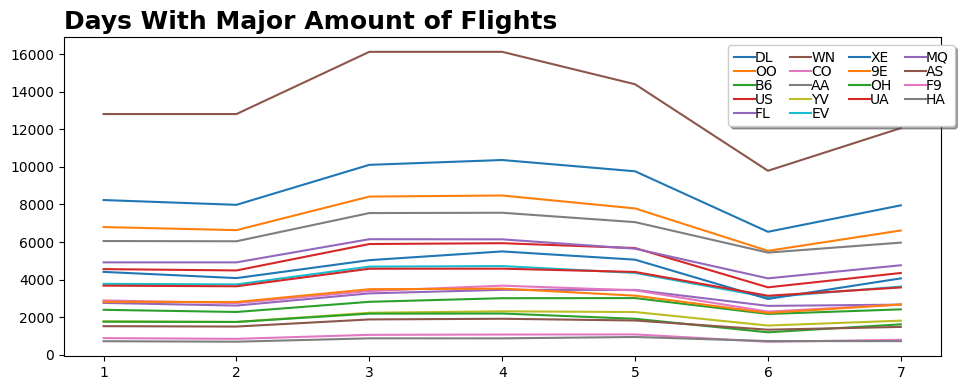

In [47]:
plt.figure(figsize=(10, 4))

for airline_takeOffs in mostFlownDaysPerAirline:
    legend = airline_takeOffs[0]
    index_input = airline_takeOffs[1].index
    dados_input = airline_takeOffs[1].values
    plt.plot(index_input, dados_input)
    plt.title(
        "Days With Major Amount of Flights", 
        loc="left", 
        fontweight="bold", 
        fontsize=18
        )
    plt.legend(
        dataset["Airline"].unique(), loc="best", ncols=4, 
        bbox_to_anchor=[0.75, 0.7], 
        columnspacing=1.0, labelspacing=0.0,
        handletextpad=0.0, handlelength=1.5,
        fancybox=True, shadow=True
        )

plt.tight_layout()
plt.show()

#### Days with the most Delaied Flights (Checking Data Balancing)

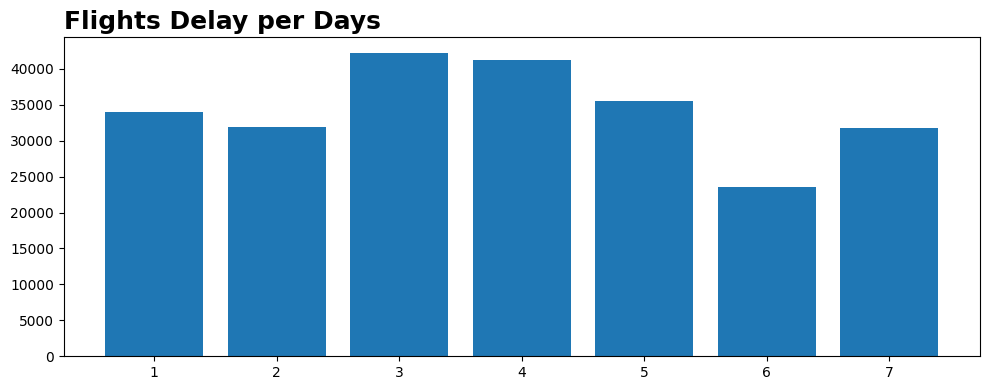

In [48]:
mostDelaiedDays = dataset.query("Class == 1")["DayOfWeek"].value_counts()

plt.figure(figsize=(10, 4))
plt.bar(x=mostDelaiedDays.index, height=mostDelaiedDays.values) #type: ignore
plt.title(
    "Flights Delay per Days", 
    loc="left", 
    fontweight="bold", 
    fontsize=18
    )
plt.tight_layout()
plt.show()

Tuesday has more delaied flights than the other days

## Category Balance Analysis

<Axes: xlabel='Class'>

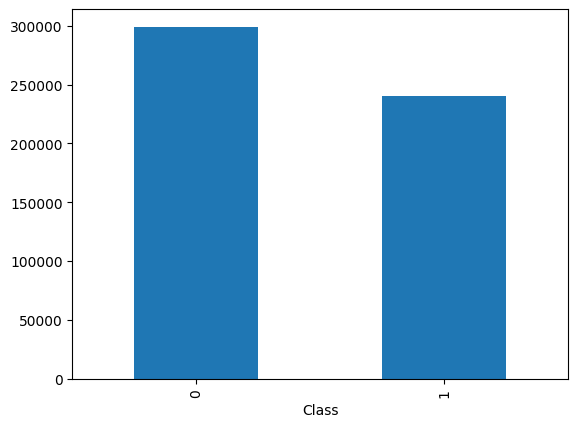

In [49]:
dataset["Class"].value_counts().plot(kind="bar")

In [50]:
class_0 = dataset['Class'].value_counts()[0]
class_1 = dataset['Class'].value_counts()[1]

diff_class_percent = ((class_0/ class_1)-1) *100
print(f"Class 0, contains: {class_0} values")
print(f"Class 1, contains: {class_1} values")
print(
    f"Difference between classes is: {round(diff_class_percent, ndigits=2)}%"
    )

Class 0, contains: 299118 values
Class 1, contains: 240264 values
Difference between classes is: 24.5%


Nearly 25% of difference between both classes.\
It is not a HUGE difference, but we can work on it, to make a gap reduction.\
Leater we'll do a SMOTE to fill up this smaller class.

## Feature Engineering

In [51]:
airline_size = range(len(dataset["Airline"].unique()))
airline_names = dataset["Airline"].unique()
factor_airline = dict(zip(airline_names, airline_size))

airport_from_size = range(len(dataset["AirportFrom"].unique()))
airport_names = dataset["AirportFrom"].unique()
factor_airport = dict(zip(airport_names, airport_from_size))

In [52]:
dataset_v1 = dataset.copy()
dataset_v1["Airline"] = dataset_v1["Airline"].map(factor_airline)
dataset_v1["AirportFrom"] = dataset_v1["AirportFrom"].map(factor_airport)
dataset_v1["AirportTo"] = dataset_v1["AirportTo"].map(factor_airport)

In [53]:
dataset_v1

,Flight,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class
0,2313.0,1296.0,141.0,0,0,144,1,0
1,6948.0,360.0,146.0,1,1,30,4,0
2,1247.0,1170.0,143.0,2,2,12,3,0
3,31.0,1410.0,344.0,3,3,26,6,0
4,563.0,692.0,98.0,4,4,0,4,0
...,...,...,...,...,...,...,...,...
539377,6973.0,530.0,72.0,1,96,47,5,1
539378,1264.0,560.0,115.0,5,49,43,4,1
539379,5209.0,827.0,74.0,9,74,0,2,1
539380,607.0,715.0,65.0,5,8,45,4,1


In [54]:
dataset_v1.drop(["Flight"], axis=1, inplace=True)

In [55]:
dataset_v1.head()

,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class
0,1296.0,141.0,0,0,144,1,0
1,360.0,146.0,1,1,30,4,0
2,1170.0,143.0,2,2,12,3,0
3,1410.0,344.0,3,3,26,6,0
4,692.0,98.0,4,4,0,4,0


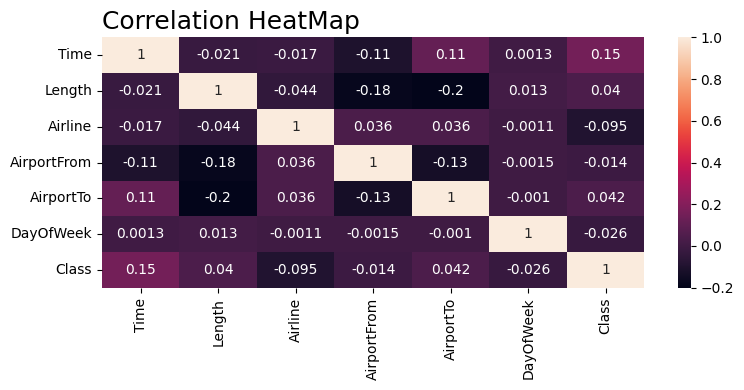

In [56]:
correlation = dataset_v1.corr()
plt.figure(figsize=(8,4))
sns.heatmap(correlation, annot=True)
plt.title("Correlation HeatMap", loc="left", fontsize=18)
plt.tight_layout()
plt.show()

In [57]:
dummyDaysOfWeek = pd.get_dummies(dataset_v1["DayOfWeek"], dtype=int)
dataset_v2 = dataset_v1.join(dummyDaysOfWeek)

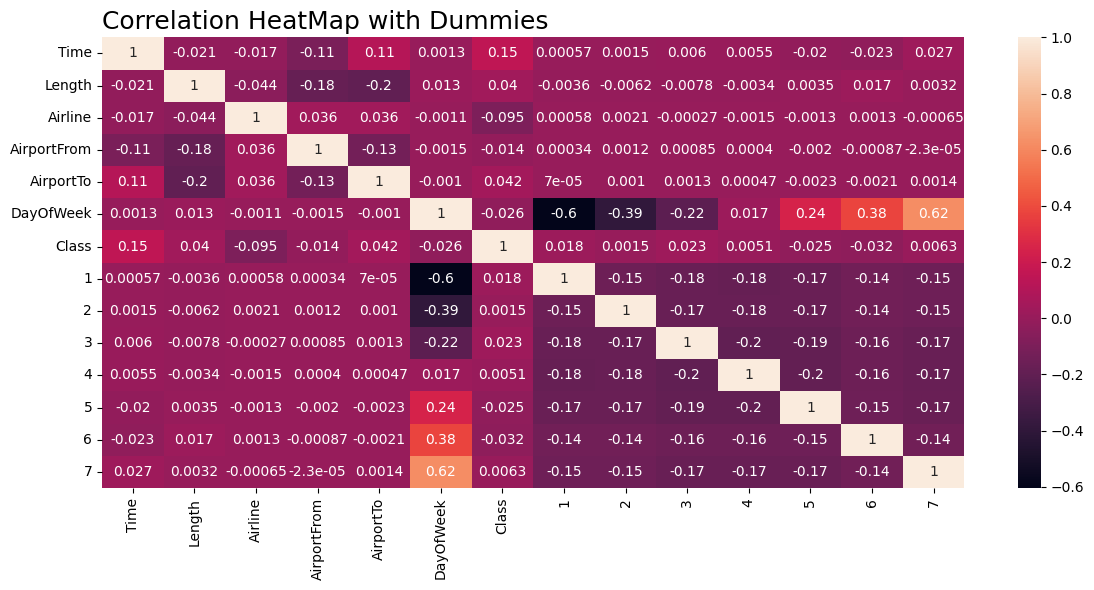

In [58]:
correlation = dataset_v2.corr()
plt.figure(figsize=(12,6))
sns.heatmap(correlation, annot=True)
plt.title("Correlation HeatMap with Dummies", loc="left", fontsize=18)
plt.tight_layout()
plt.show()

In [59]:
dataset_v3 = dataset_v1.copy()
dataset_v3["TimeDistance"] = dataset_v3["Length"] / (dataset_v3["Time"] / 60 ) # Transforming "Time" to Hours
# I'm treating "Time" as Minutes

dataset_v3.corr()

,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class,TimeDistance
Time,1.000000,-0.020610,-0.016846,-0.107336,0.112162,0.001272,0.150457,-0.309539
Length,-0.020610,1.000000,-0.044329,-0.179976,-0.201728,0.013398,0.040488,0.341990
Airline,-0.016846,-0.044329,1.000000,0.036427,0.036089,-0.001144,-0.095255,-0.022685
AirportFrom,-0.107336,-0.179976,0.036427,1.000000,-0.133173,-0.001454,-0.013599,-0.038342
AirportTo,0.112162,-0.201728,0.036089,-0.133173,1.000000,-0.001005,0.041638,-0.098309
DayOfWeek,0.001272,0.013398,-0.001144,-0.001454,-0.001005,1.000000,-0.026198,0.002863
Class,0.150457,0.040488,-0.095255,-0.013599,0.041638,-0.026198,1.000000,-0.022563
TimeDistance,-0.309539,0.341990,-0.022685,-0.038342,-0.098309,0.002863,-0.022563,1.000000


None activites done in dataset v2, or v3 increased the variables correlation\
In this case, we'll keep with the dataset_v1 with the "basic" data

## Dividing Data into X: Attribute Variables and Y: Target Varible

In [60]:
y = dataset_v1.loc[:,"Class"]
X = dataset_v1.drop(["Class"], axis=1)

### Checking VIF (Variance Inflation Factor)

In [61]:
vif = pd.DataFrame()
vif["features"] = X.columns
vif["VIF Factor"] = [variance_inflation_factor(
    X.values, 
    i) 
    for i in range(X.shape[1])]

vif

,features,VIF Factor
0,Time,6.048021
1,Length,3.685349
2,Airline,2.664427
3,AirportFrom,1.886619
4,AirportTo,2.058283
5,DayOfWeek,4.336455


Be aware that AirportFrom and AirportTo have pratically the same VIF\
It means that both variables might have the same meaning to the Classification Model

### Data Balancing

Balancing the Target Variables "Class" which was with a smaller amount of classes 1

In [62]:
overSampler = SMOTE()
X_res, y_res = overSampler.fit_resample(X, y)

In [63]:
print(X_res.shape)
print(y_res.shape)
print(dataset_v1.shape)

(598236, 6)
(598236,)
(539382, 7)


<Axes: xlabel='Class'>

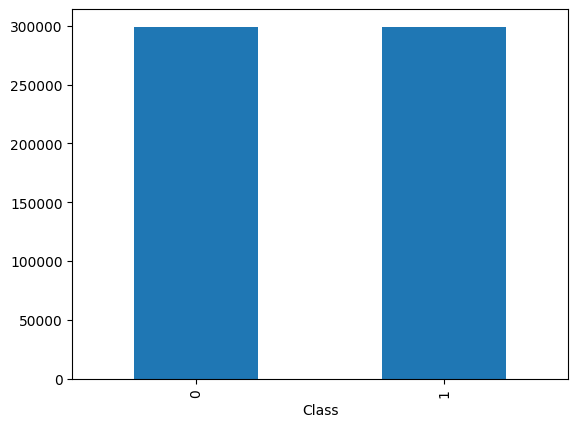

In [64]:
y_res.value_counts().plot(kind="bar")

In [65]:
print(y_res.value_counts()[0])
print(y_res.value_counts()[1])

299118
299118


The gap between classes was reduced to Zero.\
Now we can proceed to the Modeling

## Model Development

In [66]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=True
)

### Base Model

In [67]:
base_model = LogisticRegression()
base_model = base_model.fit(X_train, y_train)
base_model_result = base_model.predict(X_test)

In [68]:
score_base_model = round(accuracy_score(y_test, base_model_result) * 100, ndigits=2)
print(score_base_model, "%",  "\n")
print(pd.DataFrame(confusion_matrix(y_test, base_model_result)))

58.36 % 

       0      1
0  68269  21435
1  45951  26160


According to the VIF analysis, there were two variables with almost the same influence.\
If we take one of these variables out of the model, which are the impacts we'll have?


In [69]:
base_model_v2 = LogisticRegression()
base_model_v2 = base_model_v2.fit(X_train.drop(["AirportTo"], axis=1), y_train)
base_model_v2_result = base_model_v2.predict(X_test.drop(["AirportTo"], axis=1))

score_base_model_v2 = round(accuracy_score(y_test, base_model_v2_result) * 100, ndigits=2)
print(score_base_model_v2, "%",  "\n")
print(pd.DataFrame(confusion_matrix(y_test, base_model_v2_result)))

58.15 % 

       0      1
0  68223  21481
1  46231  25880


In [70]:
X_train["Time"] =  np.log(X_train["Time"])
X_train["Length"] =  np.log(X_train["Time"])

X_test["Time"] =  np.log(X_test["Time"])
X_test["Length"] =  np.log(X_test["Time"])

There wasn't a big impact in model's performance.\
Although, when we take a look at the False Positive and True Positive\
The model's Precision in better with both variables.

With the base model we couldn't achieve a good accuracy score, then I'll keep on with other Models/Hiperparameters.

In [71]:
def results(y_true, y_result):

    precision = precision_score(y_true, y_result) * 100
    accuracy = accuracy_score(y_true, y_result) * 100
    recall = recall_score(y_true, y_result) * 100
    conf_matrix = confusion_matrix(y_true, y_result)

    print("Model's precision: ", round(precision, ndigits=2))
    print("Model's accuracy: ", round(accuracy, ndigits=2))
    print("Model's recall: ", round(recall, ndigits=2), "\n")
    print("Model's Confusion Matrix:",)
    print(pd.DataFrame(conf_matrix))

In [72]:
model_log_reg_v1 = LogisticRegression()
model_log_reg_v1.fit(X_train, y_train)

result_log_reg_v1 = model_log_reg_v1.predict(X_test)
results(y_test, result_log_reg_v1)

Model's precision:  54.67
Model's accuracy:  58.33
Model's recall:  38.03 

Model's Confusion Matrix:
       0      1
0  66961  22743
1  44687  27424


In [73]:
model_log_reg_v2 = LogisticRegression(C=0.5, n_jobs=5, max_iter=200, solver="newton-cholesky")
model_log_reg_v2.fit(X_train, y_train)

result_log_reg_v2 = model_log_reg_v2.predict(X_test)
results(y_test, result_log_reg_v2)

Model's precision:  54.61
Model's accuracy:  58.29
Model's recall:  37.94 

Model's Confusion Matrix:
       0      1
0  66966  22738
1  44753  27358


Model is not answering the hyperparameters modification. Let's try another model

## Decision Tree Classifier

In [74]:
model_decisiontree_v1 = DecisionTreeClassifier()
model_decisiontree_v1.fit(X_train, y_train)

result_decisiontree_v1 = model_decisiontree_v1.predict(X_test)
results(y_test, result_decisiontree_v1)

Model's precision:  57.27
Model's accuracy:  60.76
Model's recall:  47.0 

Model's Confusion Matrix:
       0      1
0  64419  25285
1  38216  33895


In [75]:
model_decisiontree_v2 = DecisionTreeClassifier(
    max_depth=3, min_samples_split=2,
    min_samples_leaf=1
    )
model_decisiontree_v2.fit(X_train, y_train)

result_decisiontree_v2 = model_decisiontree_v2.predict(X_test)
results(y_test, result_decisiontree_v2)

Model's precision:  73.23
Model's accuracy:  62.95
Model's recall:  26.57 

Model's Confusion Matrix:
       0      1
0  82698   7006
1  52949  19162


Now doing the same checking but with RandomForestClassifier

## Random Forest Classifier

In [76]:
model_randomforest_v1 = RandomForestClassifier()
model_randomforest_v1.fit(X_train, y_train)

result_randomforest_v1 = model_randomforest_v1.predict(X_test)
results(y_test, result_randomforest_v1)

Model's precision:  57.39
Model's accuracy:  61.72
Model's recall:  54.76 

Model's Confusion Matrix:
       0      1
0  60387  29317
1  32625  39486


In [77]:
model_randomforest_v2 = RandomForestClassifier(n_estimators=150, max_depth=3)
model_randomforest_v2.fit(X_train, y_train)

result_randomforest_v2 = model_randomforest_v2.predict(X_test)
results(y_test, result_randomforest_v2)

Model's precision:  60.2
Model's accuracy:  62.16
Model's recall:  44.5 

Model's Confusion Matrix:
       0      1
0  68487  21217
1  40021  32090


In [78]:
model_randomforest_v3 = RandomForestClassifier(n_estimators=150, max_depth=6)
model_randomforest_v3.fit(X_train, y_train)

result_randomforest_v3 = model_randomforest_v3.predict(X_test)
results(y_test, result_randomforest_v3)

Model's precision:  65.07
Model's accuracy:  63.72
Model's recall:  40.15 

Model's Confusion Matrix:
       0      1
0  74162  15542
1  43158  28953


In [79]:
model_randomforest_v4 = RandomForestClassifier(
    n_estimators=150, max_depth=6, criterion="entropy"
    )

model_randomforest_v4.fit(X_train, y_train)

result_randomforest_v4 = model_randomforest_v4.predict(X_test)
results(y_test, result_randomforest_v4)

Model's precision:  64.83
Model's accuracy:  63.71
Model's recall:  40.58 

Model's Confusion Matrix:
       0      1
0  73830  15874
1  42851  29260


In [80]:
model_randomforest_v5 = RandomForestClassifier(
    n_estimators=150, max_depth=8, 
    )

model_randomforest_v5.fit(X_train, y_train)

result_randomforest_v5 = model_randomforest_v5.predict(X_test)
results(y_test, result_randomforest_v5)

Model's precision:  66.05
Model's accuracy:  64.22
Model's recall:  40.55 

Model's Confusion Matrix:
       0      1
0  74674  15030
1  42871  29240


Regarding to all RandomForest models, I would proceed with version 5.\
That is the one with more True Success and True Failure.
Unfortunatelly I coudn't reduce the False Success and False Failure, although applying LOG in the data, helped a little bit

## Suport Vector Machine - Classifier

In [81]:
model_svc_v1 = SVC(
    kernel="rbf", max_iter=10, 
    )

model_svc_v1.fit(X_train, y_train)

result_svc_v1 = model_svc_v1.predict(X_test)
results(y_test, result_svc_v1)

c:\Users\Vinicius\Documents\1.Data_Science\AirlineDelayPrediction\.venv\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Model's precision:  42.89
Model's accuracy:  51.57
Model's recall:  26.16 

Model's Confusion Matrix:
       0      1
0  64580  25124
1  53246  18865


In [82]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.fit_transform(X_test)

In [83]:
model_svc_v2 = SVC(
    kernel="rbf", max_iter=100, 
    )

model_svc_v2.fit(X_train_sc, y_train)

result_svc_v2 = model_svc_v2.predict(X_test_sc)
results(y_test, result_svc_v2)

c:\Users\Vinicius\Documents\1.Data_Science\AirlineDelayPrediction\.venv\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Model's precision:  36.78
Model's accuracy:  54.6
Model's recall:  2.62 

Model's Confusion Matrix:
       0     1
0  86457  3247
1  70222  1889


In [84]:
model_svc_v3 = SVC(
    kernel="rbf", max_iter=300, 
    )

model_svc_v3.fit(X_train_sc, y_train)

result_svc_v3 = model_svc_v3.predict(X_test_sc)
results(y_test, result_svc_v3)

c:\Users\Vinicius\Documents\1.Data_Science\AirlineDelayPrediction\.venv\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Model's precision:  48.64
Model's accuracy:  54.89
Model's recall:  21.81 

Model's Confusion Matrix:
       0      1
0  73103  16601
1  56387  15724


In [85]:
model_svc_v4 = SVC(
    kernel="rbf", max_iter=5, 
    )

model_svc_v4.fit(X_train_sc, y_train)

result_svc_v4 = model_svc_v4.predict(X_test_sc)
results(y_test, result_svc_v4)

c:\Users\Vinicius\Documents\1.Data_Science\AirlineDelayPrediction\.venv\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Model's precision:  51.09
Model's accuracy:  56.63
Model's recall:  62.81 

Model's Confusion Matrix:
       0      1
0  46349  43355
1  26820  45291


## Trying a deep learning Model

In [86]:
dimension = len(X_train.columns)
lenght_dataset = len(X_train)
classes = 2
epochs = 10
batch_size = 32

In [87]:
model_deep = Sequential()
model_deep.add(Dense(units=64, activation="relu", input_dim=dimension))
model_deep.add(Dense(units=32, activation="relu"))
model_deep.add(Dense(units=16, activation="relu"))
model_deep.add(Dense(units=1, activation="sigmoid"))
model_deep.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [88]:
model_deep.fit(X_train.values, y_train.values, epochs=epochs, batch_size=batch_size)

Epoch 1/10


c:\Users\Vinicius\Documents\1.Data_Science\AirlineDelayPrediction\.venv\Lib\site-packages\tensorflow\python\util\dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


11799/11799 [==============================] - 14s 1ms/step - loss: 0.0000e+00 - accuracy: 0.5546
Epoch 2/10
11799/11799 [==============================] - 13s 1ms/step - loss: 0.0000e+00 - accuracy: 0.5546
Epoch 3/10
11799/11799 [==============================] - 13s 1ms/step - loss: 0.0000e+00 - accuracy: 0.5546
Epoch 4/10
11799/11799 [==============================] - 13s 1ms/step - loss: 0.0000e+00 - accuracy: 0.5546
Epoch 5/10
11799/11799 [==============================] - 13s 1ms/step - loss: 0.0000e+00 - accuracy: 0.5546
Epoch 6/10
11799/11799 [==============================] - 13s 1ms/step - loss: 0.0000e+00 - accuracy: 0.5546
Epoch 7/10
11799/11799 [==============================] - 12s 1ms/step - loss: 0.0000e+00 - accuracy: 0.5546
Epoch 8/10
11799/11799 [==============================] - 13s 1ms/step - loss: 0.0000e+00 - accuracy: 0.5546
Epoch 9/10
11799/11799 [==============================] - 13s 1ms/step - loss: 0.0000e+00 - accuracy: 0.5546
Epoch 10/10
11799/11799 [=====

In [89]:
results_deep = model_deep.predict(X_test.values)
results(results_deep, y_test)

5057/5057 [==============================] - 6s 1ms/step
Model's precision:  0.0
Model's accuracy:  55.44
Model's recall:  0.0 

Model's Confusion Matrix:
       0      1
0  89704  72111
1      0      0


c:\Users\Vinicius\Documents\1.Data_Science\AirlineDelayPrediction\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [90]:
model_deep_v2 = Sequential()
model_deep_v2.add(Dense(units=64, activation="relu", input_dim=dimension))
model_deep_v2.add(Dense(units=32, activation="relu"))
model_deep_v2.add(Dense(units=16, activation="relu"))
model_deep_v2.add(Dense(units=1, activation="sigmoid"))
model_deep_v2.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [91]:
model_deep_v2.fit(X_train.values, y_train.values, epochs=epochs, batch_size=batch_size)

Epoch 1/10
11799/11799 [==============================] - 14s 1ms/step - loss: 0.6801 - accuracy: 0.5775
Epoch 2/10
11799/11799 [==============================] - 13s 1ms/step - loss: 0.6579 - accuracy: 0.6185
Epoch 3/10
11799/11799 [==============================] - 14s 1ms/step - loss: 0.6534 - accuracy: 0.6241
Epoch 4/10
11799/11799 [==============================] - 13s 1ms/step - loss: 0.6515 - accuracy: 0.6256
Epoch 5/10
11799/11799 [==============================] - 14s 1ms/step - loss: 0.6492 - accuracy: 0.6277
Epoch 6/10
11799/11799 [==============================] - 13s 1ms/step - loss: 0.6476 - accuracy: 0.6289
Epoch 7/10
11799/11799 [==============================] - 13s 1ms/step - loss: 0.6467 - accuracy: 0.6298
Epoch 8/10
11799/11799 [==============================] - 13s 1ms/step - loss: 0.6457 - accuracy: 0.6308
Epoch 9/10
11799/11799 [==============================] - 13s 1ms/step - loss: 0.6448 - accuracy: 0.6316
Epoch 10/10
11799/11799 [==============================

In [92]:
results_deep_v2 = model_deep_v2.predict(X_test.values)
results([round(value[0]) for value in results_deep_v2], y_test)

5057/5057 [==============================] - 5s 897us/step
Model's precision:  37.17
Model's accuracy:  63.12
Model's recall:  65.1 

Model's Confusion Matrix:
       0      1
0  75333  45307
1  14371  26804


In [93]:
model_deep_v3 = Sequential()
model_deep_v3.add(Dense(units=64, activation="relu", input_dim=dimension))
model_deep_v3.add(Dense(units=32, activation="relu"))
model_deep_v3.add(Dense(units=16, activation="relu"))
model_deep_v3.add(Dense(units=1, activation="sigmoid"))
model_deep_v3.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Changing batch_size
model_deep_v3.fit(X_train.values, y_train.values, epochs=epochs, batch_size=16)

Epoch 1/10
23598/23598 [==============================] - 27s 1ms/step - loss: 0.6755 - accuracy: 0.5879
Epoch 2/10
23598/23598 [==============================] - 27s 1ms/step - loss: 0.6534 - accuracy: 0.6241
Epoch 3/10
23598/23598 [==============================] - 26s 1ms/step - loss: 0.6544 - accuracy: 0.6220
Epoch 4/10
23598/23598 [==============================] - 26s 1ms/step - loss: 0.6502 - accuracy: 0.6261
Epoch 5/10
23598/23598 [==============================] - 29s 1ms/step - loss: 0.6474 - accuracy: 0.6276
Epoch 6/10
23598/23598 [==============================] - 27s 1ms/step - loss: 0.6463 - accuracy: 0.6285
Epoch 7/10
23598/23598 [==============================] - 26s 1ms/step - loss: 0.6484 - accuracy: 0.6240
Epoch 8/10
23598/23598 [==============================] - 26s 1ms/step - loss: 0.6456 - accuracy: 0.6285
Epoch 9/10
23598/23598 [==============================] - 27s 1ms/step - loss: 0.6449 - accuracy: 0.6296
Epoch 10/10
23598/23598 [==============================

In [94]:
results_deep_v3 = model_deep_v3.predict(X_test.values)
results_deep_v3 = [round(value[0]) for value in results_deep_v3]
results(results_deep_v3, y_test)

5057/5057 [==============================] - 4s 836us/step
Model's precision:  32.61
Model's accuracy:  62.88
Model's recall:  67.23 

Model's Confusion Matrix:
       0      1
0  78240  48595
1  11464  23516


In [95]:
fp_rate, tp_rate, thresholds = roc_curve(y_test, results_deep_v3)
roc_auc = auc(fp_rate, tp_rate)

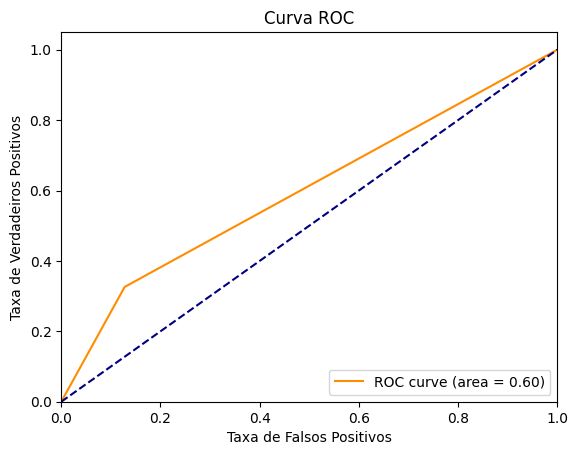

In [96]:
plt.plot(fp_rate, tp_rate, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

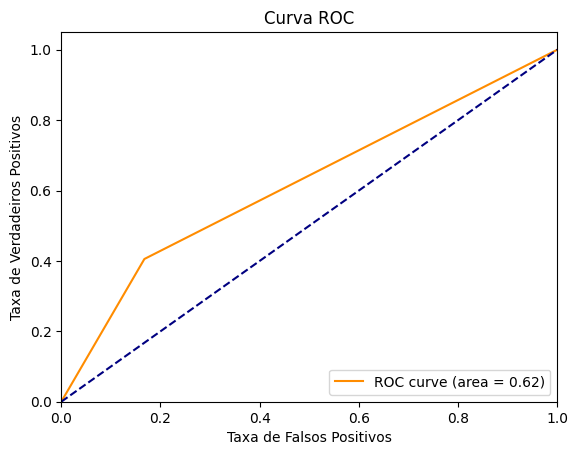

In [97]:
fp_rate, tp_rate, thresholds = roc_curve(y_test, result_randomforest_v5)
roc_auc = auc(fp_rate, tp_rate)

plt.plot(fp_rate, tp_rate, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()